In [1]:
import shap
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification
from tqdm.auto import tqdm
import ast
import os
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


🔧 Using device: cuda


In [2]:
def log(msg, path="../outputs/logs/shap_log.txt"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "a", encoding="utf-8") as f:
        f.write(msg + "\n")
    print(msg)

log("Starting SHAP explanation for toxic span detection")


🚀 Starting SHAP explanation for toxic span detection


In [3]:
# Load Toxic Spans data
# Strip whitespace-only lines and drop empties to avoid tokenizer errors
df = pd.read_csv("../data/toxic_spans.csv")
df["position"] = df["position"].apply(ast.literal_eval)
df["text_of_post"] = df["text_of_post"].astype(str).apply(lambda x: x.strip())
df = df[df["text_of_post"] != ""].reset_index(drop=True)
log(f"Loaded {len(df)} samples from toxic_spans.csv")


📊 Loaded 11006 samples from toxic_spans.csv


In [4]:
# Load tokenizer and the fine-tuned comment-level BERT classifier
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
model.load_state_dict(torch.load("../outputs/model/bert_toxic_classifier.pt", map_location=device))
model.to(device).eval()
log("Loaded fine-tuned BERT model for toxicity classification")


`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded fine-tuned BERT model for toxicity classification


In [5]:
class WrappedModel:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def __call__(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        elif isinstance(texts, (pd.Series, np.ndarray)):
            texts = texts.tolist()
        enc = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        enc = {k: v.to(self.device) for k, v in enc.items()}
        with torch.no_grad():
            outputs = self.model(**enc)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        return probs[:, 1].detach().cpu().numpy()


In [6]:
# SHAP text masker uses the same tokenizer to keep tokenization consistent with the model
wrapped_model = WrappedModel(model, tokenizer, device)
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(wrapped_model, masker)
log("Initialized SHAP explainer")


⚙️ Initialized SHAP explainer


In [7]:
# Iterate through all comments, compute SHAP values, and align token-level attributions
# to character indices via the tokenizer's offset mapping. Compute precision/recall/F1
# vs. human character-level spans
results = []
threshold = 0.5

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text_of_post"]
    gt_spans = set(row["position"])

    try:
        # Compute SHAP values for this single text.
        shap_values = explainer([text])
        scores = shap_values.values[0]
        tokens = shap_values.data[0]

        # Re-tokenize the same text to get character offsets for each token position.
        enc = tokenizer(text, return_offsets_mapping=True, truncation=True, padding="max_length", max_length=128)
        offsets = enc["offset_mapping"]

        # Build predicted character set from tokens whose SHAP value >= threshold
        predicted = set()
        for j, (start, end) in enumerate(offsets):
            if start == end or j >= len(scores):
                continue
            if scores[j] >= threshold:
                predicted.update(range(start, end))

        # Character-level confusion components
        tp = len(predicted & gt_spans)
        fp = len(predicted - gt_spans)
        fn = len(gt_spans - predicted)

        # Per-sample precision/recall/F1 with 1e-6 epsilon to avoid division-by-zero
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)

        results.append({
            "index": i,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "true_pos": tp,
            "false_pos": fp,
            "false_neg": fn,
            "text": text,
            "tokens": tokens,
            "scores": scores
        })

    except Exception as e:
        log(f"SHAP error on row {i}: {e}\n   ↳ text: {repr(text)}")


  0%|          | 0/11006 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:13, 13.09s/it]               


In [8]:
# Save per-sample SHA metrics for analysis/plots
df_results = pd.DataFrame(results)
os.makedirs("../outputs/shap", exist_ok=True)
df_results.to_csv("../outputs/shap/evaluation_metrics.csv", index=False)
log("Saved: ../outputs/shap/evaluation_metrics.csv")

desc = df_results[["precision", "recall", "f1"]].describe().round(4).to_string()
log(f"\nSHAP Metrics Summary:\n{desc}")


💾 Saved: ../outputs/shap/evaluation_metrics.csv

📋 SHAP Metrics Summary:
        precision      recall          f1
count  11006.0000  11006.0000  11006.0000
mean       0.2819      0.2421      0.2545
std        0.4499      0.4051      0.4164
min        0.0000      0.0000      0.0000
25%        0.0000      0.0000      0.0000
50%        0.0000      0.0000      0.0000
75%        1.0000      0.5000      0.6667
max        1.0000      1.0000      1.0000


In [10]:
try:
    os.makedirs("../outputs/shap/figures", exist_ok=True)
    shap_html = shap.plots.text(shap_values[0], display=False)
    with open("../outputs/shap/figures/example_shap_plot.html", "w", encoding="utf-8") as f:
        f.write(shap_html)
    log("Saved: SHAP text visualization for first sample")
except Exception as e:
    log(f"Failed to save SHAP text plot: {e}")


📝 Saved: SHAP text visualization for first sample


In [11]:
shap.plots.text(shap_values[0])

📊 Saved: ../outputs/shap/figures/f1_distribution.png


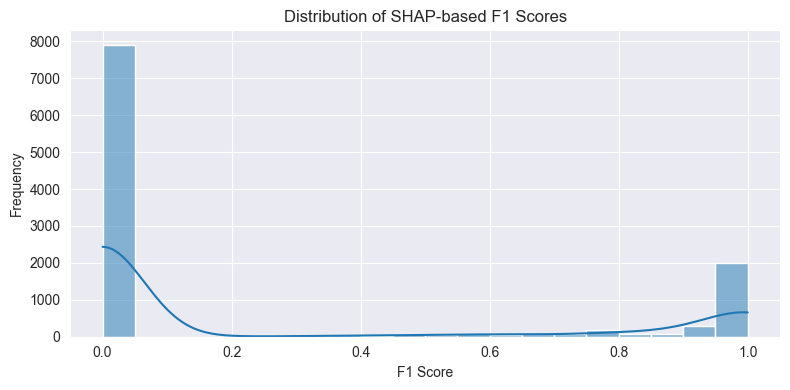

In [12]:
# Plot distribution of per-sample SHA F1 scores
plt.figure(figsize=(8, 4))
sns.histplot(df_results["f1"], bins=20, kde=True)
plt.title("Distribution of SHAP-based F1 Scores")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.tight_layout()

fig_path = "../outputs/shap/figures/f1_distribution.png"
plt.savefig(fig_path)
log(f"Saved: {fig_path}")
plt.show()